# Training a neural network to predict the value of the monthly averaged CONUS temp
## Explore differences of prediction skill with various preprocessing methods

## [Open in Google Colab](https://colab.research.google.com/github/mbarcodia/bams-preprocess/blob/main/code/CONUS_temp_prediction_r2.ipynb#scrollTo=7JKIaA8yF4F0)


In [1]:
%pip install seaborn cartopy fsspec requests aiohttp h5netcdf wget cftime

import wget

import xarray as xr
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

import pandas as pd
import cftime


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix

# checking to see

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Convert the float years to cftime.DatetimeNoLeap with both year and month
def convert_to_cftime_yr_mon(year):
    int_year = int(year)
    fractional_year = year - int_year
    month = (
        int(fractional_year * 12) + 1
    )  # Calculate the month from the fractional part
    return cftime.DatetimeNoLeap(int_year, month, 1)

In [3]:
# Set random seed for reproducibility
random_seed = 567
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# =============================
# 1. Load, Inspect, and Prepare Data
# =============================

# obs_dataset_full = xr.open_dataset(
#     "/Users/marcodia/Downloads/North_America_TAVG_Gridded_1deg.nc"
# )  # (fsspec.open(url).open())
# obs_dataset = obs_dataset_full.sel(time=slice("1900-01-01", "2025-05-01"))

# Use link to download data directly from the data source
!wget -O North_America_TAVG_Gridded_1deg.nc https://storage.googleapis.com/berkeley-earth-temperature-hr/regional/gridded/North_America_TAVG_Gridded_1deg.nc
obs_dataset_full = xr.open_dataset(
    "North_America_TAVG_Gridded_1deg.nc"
)  # (fsspec.open(url).open())
obs_dataset = obs_dataset_full.sel(time=slice("1900-01-01", "2025-05-01"))

# Apply Time Conversion and add climatology to anomalies for full dataset

obs_dataset["time"] = xr.DataArray(
    [convert_to_cftime_yr_mon(year) for year in obs_dataset["time"].values], dims="time"
)  # cftime.DatetimeNoLeap with both year and month
obs_anom = obs_dataset.temperature
obs_anom = obs_anom.rename({"latitude": "lat", "longitude": "lon"})
obs_climo = obs_dataset.climatology
obs_climo = obs_climo.rename({"latitude": "lat", "longitude": "lon"})

# Extract the month number (1-12) from the cftime.DatetimeNoLeap time dimension
month_indices = obs_anom["time"].dt.month

# Add the climatology to the anomalies, ensuring the output maintains the original dimensions
obs_full = obs_anom.groupby(month_indices).apply(
    lambda x, month: x + obs_climo.sel(month_number=month - 1), args=(month_indices,)
)
obs_full = obs_full.transpose("time", "lat", "lon")

obs_full_raw = xr.Dataset({"tas": obs_full})
obs_full_raw = obs_full_raw[["time", "lat", "lon", "tas"]]

obs_full_raw.attrs["description"] = (
    "This dataset contains the full timeseries of BEST observations over land only with monthly climatology added to the anomalies. The data is in deg C"
)
obs_full_raw = obs_full_raw.tas

# Select Region for calculations; below are for SW US
lat_min, lat_max = 29, 39
lon_min, lon_max = -117, -104

# Alaska
# lat_min, lat_max = 51, 71
# lon_min, lon_max = -179, -130

In [4]:
# =============================
# 2. Define Data Splits
# =============================
lead = 1  # number of months ahead to predict

exp_name = "clean"

if exp_name in ["split", "split_trend_climo"]:
    # No gap in time between train, val, test
    train_start, train_end = "1900-01-01", "1999-12-01"
    val_start, val_end = "2000-01-01", "2002-08-01"
    test_start, test_end = "2002-09-01", "2024-12-01"
else:
    # Clean data split with temporal gaps
    train_start, train_end = "1900-01-01", "1979-12-01"
    val_start, val_end = "1981-07-01", "2001-02-01"
    test_start, test_end = "2002-09-01", "2024-12-01"

# After alignment, Y uses same dates as X
train_start_y, train_end_y = train_start, train_end
val_start_y, val_end_y = val_start, val_end
test_start_y, test_end_y = test_start, test_end

# Convert to datetime
train_start_date = pd.to_datetime(train_start)
train_end_date = pd.to_datetime(train_end)
val_start_date = pd.to_datetime(val_start)
val_end_date = pd.to_datetime(val_end)
test_start_date = pd.to_datetime(test_start)
test_end_date = pd.to_datetime(test_end)

train_start_date_y = pd.to_datetime(train_start_y)
train_end_date_y = pd.to_datetime(train_end_y)
val_start_date_y = pd.to_datetime(val_start_y)
val_end_date_y = pd.to_datetime(val_end_y)
test_start_date_y = pd.to_datetime(test_start_y)
test_end_date_y = pd.to_datetime(test_end_y)

/opt/anaconda3/envs/env-enso-preprocessing/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/env-enso-preprocessing/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/env-enso-preprocessing/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


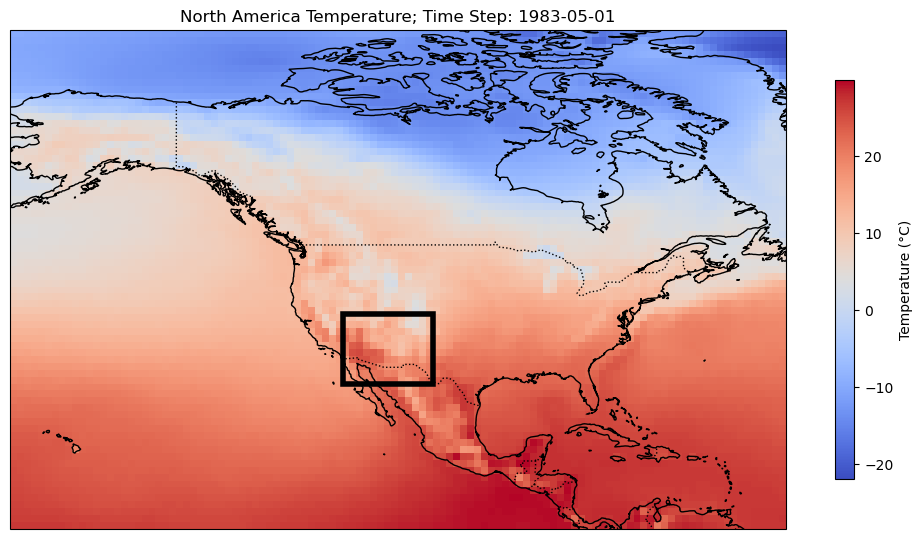

In [5]:
# Plot Data to Check
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

ax.set_extent([-165, -53, 8, 80], crs=ccrs.PlateCarree())

ax.coastlines(resolution="50m")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

mesh = ax.pcolormesh(
    obs_full_raw.lon,
    obs_full_raw.lat,
    obs_full_raw[1000],
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    shading="auto",
)

cbar = plt.colorbar(mesh, ax=ax, orientation="vertical", shrink=0.7, pad=0.05)
cbar.set_label("Temperature (°C)")

# Add box over sliced region
rect = mpatches.Rectangle(
    (lon_min, lat_min),
    lon_max - lon_min,
    lat_max - lat_min,
    linewidth=4,
    edgecolor="black",
    facecolor="none",  # Transparent fill
    transform=ccrs.PlateCarree(),
    zorder=10,
)

ax.add_patch(rect)

plt.title(
    "North America Temperature; Time Step: {}".format(
        str(obs_full_raw.time[1000].values)[:10]
    )
)
plt.tight_layout()
plt.show()

In [6]:
# =============================
# 3. Compute and Remove Monthly Climatology
#    Note that the original dataset contained anomalies and climatology for the 1951-1980 period and I added the climatology back in.
#    Using the methodology below for the same time period, the climatologies seem to a 10^-2 deg C difference, confirming the methodology is sound.
# =============================

# Compute climatology (baseline period, within and outside of training period)
if exp_name in ["climo", "split_trend_climo"]:
    climo_period = obs_full_raw.sel(time=slice("1991-01-01", "2020-12-01"))

else:
    climo_period = obs_full_raw.sel(
        time=slice("1941-01-01", "1970-12-01")
    )  # ensure this is within training period

climatology = climo_period.groupby("time.month").mean(dim="time")

# Remove climatology to calculate anomalies
anomalies = obs_full_raw.groupby("time.month") - climatology

/opt/anaconda3/envs/env-enso-preprocessing/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/env-enso-preprocessing/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/env-enso-preprocessing/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


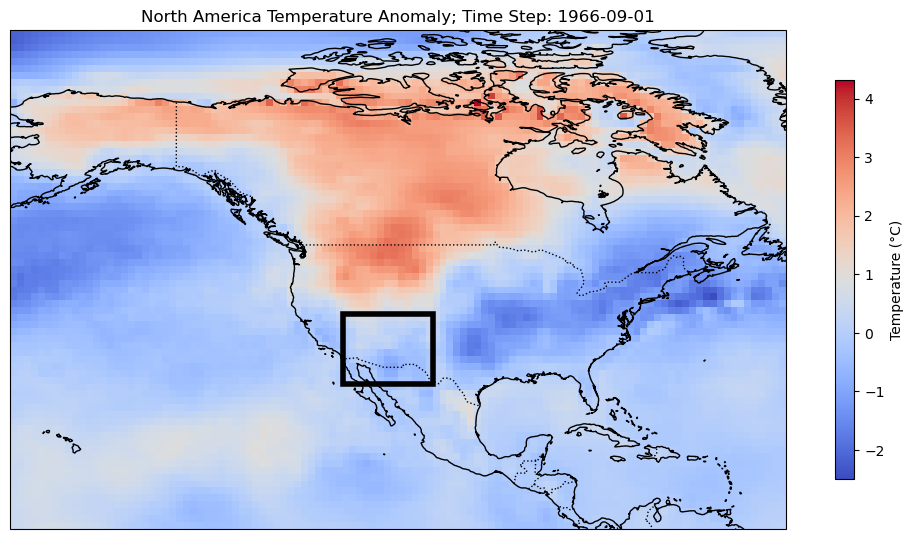

In [7]:
# Plot Data to Check
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

ax.set_extent([-165, -53, 8, 80], crs=ccrs.PlateCarree())

ax.coastlines(resolution="50m")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

mesh = ax.pcolormesh(
    anomalies.lon,
    anomalies.lat,
    anomalies[800],
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    shading="auto",
)

cbar = plt.colorbar(mesh, ax=ax, orientation="vertical", shrink=0.7, pad=0.05)
cbar.set_label("Temperature (°C)")

rect = mpatches.Rectangle(
    (lon_min, lat_min),
    lon_max - lon_min,
    lat_max - lat_min,
    linewidth=4,
    edgecolor="black",
    facecolor="none",  # Transparent fill
    transform=ccrs.PlateCarree(),
    zorder=10,
)

ax.add_patch(rect)

plt.title(
    "North America Temperature Anomaly; Time Step: {}".format(
        str(obs_full_raw.time[800].values)[:10]
    )
)
plt.tight_layout()
plt.show()

/var/folders/v6/n_npdtk14cn2qb_fv2f98h1w0000gq/T/ipykernel_6889/841903547.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


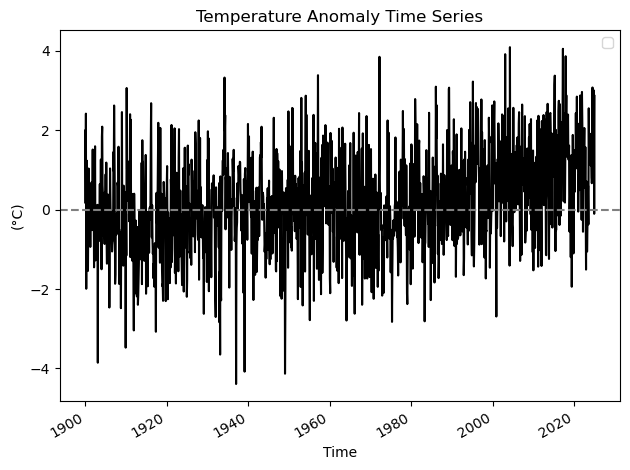

In [8]:
# =============================
# 4. Extract SW US Region to create timeseries
#    Latitudinal weighting is used to compute area-weighted average of the gridded data
#    Since the magnitude of the data is relatively small and for the demonstration purposes of preprocessing methods, no standardization is applied
# =============================

# Region defined by black box above
slice_region = anomalies.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

# Compute area-weighted average SST anomalies over Nino 3.4 region
weights = np.cos(np.deg2rad(slice_region["lat"]))
temp_index_cf = slice_region.weighted(weights).mean(("lon", "lat"))

# Convert time variable back to xarray.DataArray
# Extract time coordinate as cftime objects
time_cftime = temp_index_cf["time"].values

# Convert each cftime.datetime to ISO string (e.g., 'YYYY-MM-DD')
time_str = [t.strftime("%Y-%m-%d") for t in time_cftime]

# Now convert those strings to datetime64
time_converted = pd.to_datetime(time_str)

# Replace time coordinate in temp_index
temp_index = temp_index_cf.assign_coords(time=("time", time_converted))

# Plot timeseries
temp_index.plot.line(color="black")

plt.axhline(0, color="gray", linestyle="--")
plt.title("Temperature Anomaly Time Series")
plt.ylabel("(°C)")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()

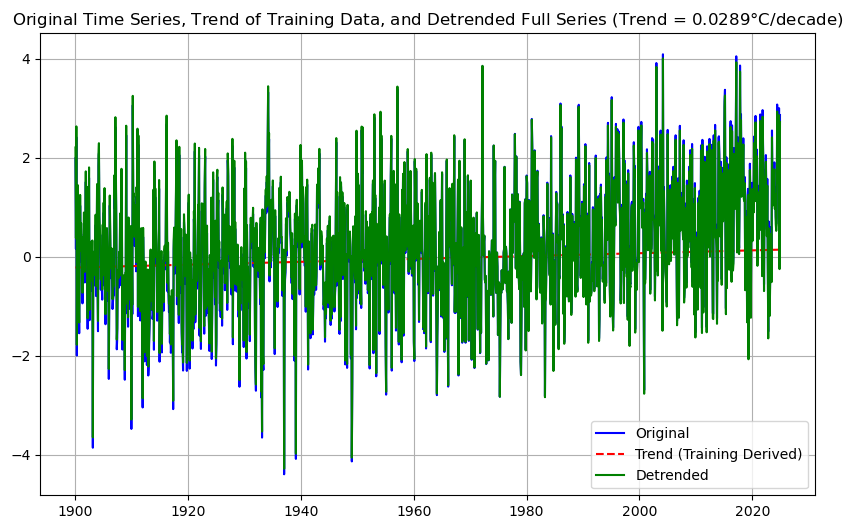

In [9]:
# =============================
# 5. Detrend Data
# =============================

# Convert training time to numeric values for linear regression for trend
if exp_name in ["trend", "split_trend_climo"]:
    time_numeric = np.arange(len(temp_index.time))
    coeffs = np.polyfit(
        time_numeric, temp_index.sel(time=slice(train_start, test_end)), 1
    )

else:
    # time_numeric = np.arange(len(train_data.time))
    time_numeric = np.arange(
        len(temp_index.sel(time=slice(train_start, train_end)).time)
    )
    coeffs = np.polyfit(
        time_numeric, temp_index.sel(time=slice(train_start, train_end)), 1
    )


slope, intercept = coeffs

# Compute trend over selected time
time_numeric_full = np.arange(len(temp_index.time))
trend = slope * time_numeric_full + intercept

# Remove the trend from the dataset
temp_detrended = temp_index - trend

# Plot detrended index
plt.figure(figsize=(10, 6))
plt.plot(temp_index.time, temp_index, label="Original", color="blue")
plt.plot(
    temp_index.time,
    trend,
    label="Trend (Training Derived)",
    linestyle="--",
    color="red",
)
plt.plot(temp_index.time, temp_detrended, label="Detrended", color="green")
plt.title(
    f"Original Time Series, Trend of Training Data, and Detrended Full Series (Trend = {slope*120:.4f}"  # 12 months * 10 years
    + r"$\degree$C/decade)"
)
plt.legend()
plt.grid()
plt.show()
# plt.savefig(f"../figs/temp_detrended_{exp_name}.png", dpi=300)

In [10]:
# Apply 5-month rolling mean to help with visualization
temp_smoothed = temp_detrended.rolling(time=5, center=False).mean()

# Drop NaNs introduced by rolling mean
temp_smoothed = temp_smoothed.dropna(dim="time")
temp_detrended = temp_smoothed

# =============================
# 6. Shift Data to Account for Lead Time
# =============================

# Prepare the data: input is all months except the x-lead last months; output is shifted by the lead
if lead == 0:
    temp_X = temp_detrended
    temp_Y = temp_detrended
else:
    temp_X = temp_detrended[:-lead]
    temp_Y = temp_detrended[lead:]

temp_Y["time"] = (
    temp_X.time.values
)  # makes features at time t predict labels at time t+lead

In [11]:
# =============================
# 7. Create Lagged Features
# =============================


def create_lagged_features(temp_X, lag_steps):
    """
    Create lagged features from a 1D xarray.DataArray, ensuring proper alignment
    with past data.

    Args:
        temp_X (xarray.DataArray): Input data of shape (time,).
        lag_steps (int): Number of lag steps to include.

    Returns:
        X_features (xarray.DataArray): Expanded data with shape (time - lag_steps + 1, lag_steps),
                                       aligned with past data.
    """
    # Create lagged arrays by shifting temp_X forward in time
    lagged_list = [
        temp_X.shift(time=lag).assign_coords(lag=lag) for lag in range(lag_steps)
    ]
    X_features = xr.concat(
        lagged_list, dim="lag"
    )  # Combine lagged arrays along a new 'lag' dimension
    X_features = X_features.transpose(
        "time", "lag"
    )  # Transpose dimensions to (time, lag)
    X_features["lag"] = range(
        lag_steps
    )  # Ensure lag dimension has descriptive labels (e.g., lag 0 = no lag, lag 1 = 1-step lag, etc.)
    X_features = X_features.isel(
        time=slice(lag_steps - 1, None)
    )  # Drop the first `lag_steps - 1` rows where data is incomplete

    return X_features


lag_steps = 4

# Create lagged features
temp_X = create_lagged_features(temp_X, lag_steps)
temp_Y = temp_Y[lag_steps - 1 :]  # Drop the first `lag_steps - 1` rows from the output

X_train shape: (953, 4), Y_train shape: (953,)
X_val shape: (236, 4), Y_val shape: (236,)
X_test shape: (267, 4), Y_test shape: (267,)


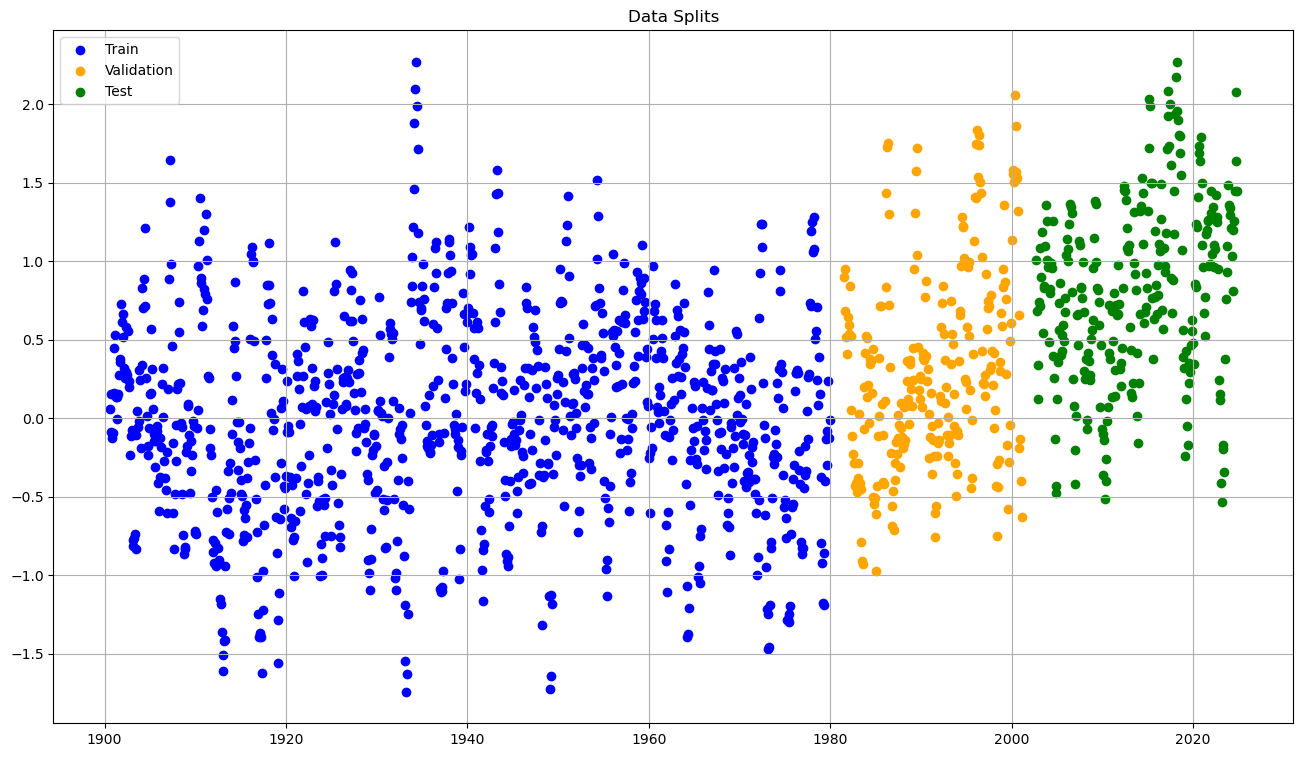

In [12]:
# =============================
# 8. Create Data Splits for Training, Validation, and Testing
#    Recommended Practice is to split data first, but we split here for the purpose of showing different preprocessing steps
#    The clean experiment ensures no data leakage between train, val, and test sets
# =============================

# Create boolean masks to select data by time using the defined periods
train_mask_X = (temp_X.time >= train_start_date) & (temp_X.time <= train_end_date)
val_mask_X = (temp_X.time >= val_start_date) & (temp_X.time <= val_end_date)
test_mask_X = (temp_X.time >= test_start_date) & (temp_X.time <= test_end_date)

train_mask_Y = (temp_Y.time >= train_start_date_y) & (temp_Y.time <= train_end_date_y)
val_mask_Y = (temp_Y.time >= val_start_date_y) & (temp_Y.time <= val_end_date_y)
test_mask_Y = (temp_Y.time >= test_start_date_y) & (temp_Y.time <= test_end_date_y)

# Apply masks to get training, validation, and testing sets (dropping the unmatched time points)
X_train = temp_X.where(train_mask_X, drop=True)
X_val = temp_X.where(val_mask_X, drop=True)
X_test = temp_X.where(test_mask_X, drop=True)

Y_train = temp_Y.where(train_mask_Y, drop=True)
Y_val = temp_Y.where(val_mask_Y, drop=True)
Y_test = temp_Y.where(test_mask_Y, drop=True)

# Verify shapes
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

# =============================
# 9. Visualize Data Splits
# =============================

plt.figure(figsize=(16, 9))
plt.scatter(X_train.time, X_train[:, 0], color="blue", label="Train")
plt.scatter(X_val.time, X_val[:, 0], color="orange", label="Validation")
plt.scatter(X_test.time, X_test[:, 0], color="green", label="Test")
plt.title("Data Splits")
plt.legend()
plt.grid()
plt.show()
# plt.savefig(f"../figs/data_splits_{exp_name}.png", dpi=300)

In [13]:
# =============================
# 10. Convert Data to NumPy for Pytorch use
# =============================

# Convert xarray DataArray to NumPy arrays using the .values attribute
X_train_np = X_train.values  # Extract NumPy array from xarray DataArray
Y_train_np = Y_train.values  # Similarly for labels

X_val_np = X_val.values
Y_val_np = Y_val.values

X_test_np = X_test.values
Y_test_np = Y_test.values

# Reshape the data to ensure each sample has one feature
X_train_np = X_train_np.reshape(-1, len(X_train[0, :]))
X_val_np = X_val_np.reshape(-1, len(X_train[0, :]))
X_test_np = X_test_np.reshape(-1, len(X_train[0, :]))
print("X and Y training shapes")
print(X_train_np.shape)  # Should be (num_samples, num_features)
print(Y_train_np.shape)  # Should be (num_samples,)

X and Y training shapes
(953, 4)
(953,)


In [14]:
# Some time stamp checks
print(temp_index.time)
print("X val time")
print(X_val.time)
print("Y val time")
print(Y_val.time)

<xarray.DataArray 'time' (time: 1500)>
array(['1900-01-01T00:00:00.000000000', '1900-02-01T00:00:00.000000000',
       '1900-03-01T00:00:00.000000000', ..., '2024-10-01T00:00:00.000000000',
       '2024-11-01T00:00:00.000000000', '2024-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2024-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
X val time
<xarray.DataArray 'time' (time: 236)>
array(['1981-07-01T00:00:00.000000000', '1981-08-01T00:00:00.000000000',
       '1981-09-01T00:00:00.000000000', ..., '2000-12-01T00:00:00.000000000',
       '2001-01-01T00:00:00.000000000', '2001-02-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1981-07-01 1981-08-01 ... 2001-02-01
    month    (time) int64 7 8 9 10 11 12 1 2 3 4 5 ... 4 5 6 7 8 9 10 11 12 1 2
Y val time
<xarray.DataArray 'time' (time: 236)>
array(['1981-07-01T00:00

# Neural Network Setup

##### The preprocessing of the input and output data is complete. Now, we set up the neural networks to made our predictions.

## Hyperparameter Selection

In [15]:
# Define hyperparameters
input_size = X_train_np.shape[1]
hiddens = [100, 50, 50]
output_size = 1  # only predicting one value for each prediction
learning_rate = 0.00001
n_epochs = 1000
batch_size = 64
l2_reg = 0  # 0.01  # L2 ridge regularization

patience = 50  # Number of epochs to wait for improvement
min_delta = 0.0001  # Minimum change to qualify as an improvement
best_val_loss = float("inf")
patience_counter = 0
best_model_state = None

In [16]:
class Predictor_Regression(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(
            Predictor_Regression, self
        ).__init__()  # used to inherit functionality from nn.Module
        self.layers = nn.ModuleList()

        # Add the first hidden layer
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))

        # Add additional hidden layers
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))

        # Add the output layer (no softmax for regression)
        self.layers.append(nn.Linear(hidden_layers[-1], output_size))

    def forward(self, x):
        # Pass input through each hidden layer with ReLU activation
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        # Output layer (no activation for regression)
        return self.layers[-1](x)

Epoch 1/1000, Train Loss: 0.416748, Val Loss: 0.589866
  → New best validation loss: 0.589866
Epoch 2/1000, Train Loss: 0.416137, Val Loss: 0.586706
  → New best validation loss: 0.586706
Epoch 3/1000, Train Loss: 0.412920, Val Loss: 0.583562
  → New best validation loss: 0.583562
Epoch 4/1000, Train Loss: 0.412277, Val Loss: 0.580646
  → New best validation loss: 0.580646
Epoch 5/1000, Train Loss: 0.409199, Val Loss: 0.577570
  → New best validation loss: 0.577570
Epoch 6/1000, Train Loss: 0.408196, Val Loss: 0.574709
  → New best validation loss: 0.574709
Epoch 7/1000, Train Loss: 0.405677, Val Loss: 0.571895
  → New best validation loss: 0.571895
Epoch 8/1000, Train Loss: 0.404763, Val Loss: 0.569161
  → New best validation loss: 0.569161
Epoch 9/1000, Train Loss: 0.403164, Val Loss: 0.566487
  → New best validation loss: 0.566487
Epoch 10/1000, Train Loss: 0.401400, Val Loss: 0.563835
  → New best validation loss: 0.563835
Epoch 11/1000, Train Loss: 0.399730, Val Loss: 0.561296
  →

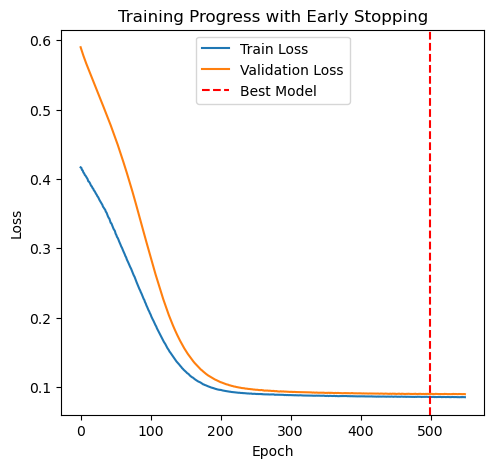

In [17]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).reshape(
    -1, input_size
)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32).reshape(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).reshape(-1, input_size)
Y_val_tensor = torch.tensor(Y_val.values, dtype=torch.float32).reshape(-1, 1)

# DataLoader for batching
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor),
    batch_size=batch_size,
    shuffle=True,
)

val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_val_tensor, Y_val_tensor),
    batch_size=batch_size,
    shuffle=False,
)

# Initialize the model, loss function, and optimizer
model = Predictor_Regression(input_size, hiddens, output_size)
criterion = (
    nn.MSELoss()
)  # alternatives: nn.L1Loss(), nn.SmoothL1Loss(), nn.MSELoss(), nn.HuberLoss(), nn.PoissonNLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)

# Training loop
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate average losses
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(
        f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}"
    )

    # Early stopping check
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model state
        best_model_state = model.state_dict().copy()
        print(f"  → New best validation loss: {best_val_loss:.6f}")
    else:
        patience_counter += 1
        print(f"  → No improvement for {patience_counter} epoch(s)")

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.6f}")
            break

# Load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model weights")

# Plot the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.axvline(
    x=len(val_losses) - patience_counter - 1,
    color="r",
    linestyle="--",
    label="Best Model",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Progress with Early Stopping")
plt.show()
# plt.savefig(f"../figs/training_loss_{exp_name}.png", dpi=300)

## Evaluate the model on the test set

In [18]:
# Y_test_np_save = xr.DataArray(Y_test_np, coords={"time": Y_test.time}, dims=["time"])
# # Save test data for later use
# Y_test_np_save.to_netcdf(f"Y_clean_labels_lead{lead}mo_lead.nc")

In [19]:
test_data = torch.tensor(X_test_np, dtype=torch.float32)  # Feature data for testing
test_labels = torch.tensor(Y_test_np, dtype=torch.float32)  # Testing labels

# Create the test dataset and loader
test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_data = torch.tensor(X_val_np, dtype=torch.float32)  # Feature data for testing
val_labels = torch.tensor(Y_val_np, dtype=torch.float32)  # Testing labels
val_dataset = TensorDataset(val_data, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_data = torch.tensor(X_train_np, dtype=torch.float32)  # Feature data for testing
train_labels = torch.tensor(Y_train_np, dtype=torch.float32)  # Testing labels
train_dataset = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Set the model to evaluation mode
model.eval()

# To store predictions and original indices
predictions = []
predictions_val = []
predictions_train = []

original_indices = []
original_indices_val = []
original_indices_train = []

with torch.no_grad():  # No need to track gradients during evaluation
    for batch_idx, (data, labels) in enumerate(test_loader):
        # Get the original indices of the current batch
        original_indices.extend(batch_idx * batch_size + torch.arange(data.size(0)))

        # Forward pass to get predictions
        output = model(data)
        predictions.append(output)

# Concatenate the predictions and convert to a tensor
predictions = torch.cat(predictions, dim=0)

# Convert original indices to a tensor for easy indexing if needed
original_indices = torch.tensor(original_indices)

with torch.no_grad():  # No need to track gradients during evaluation
    for batch_idx, (data, labels) in enumerate(val_loader):
        # Get the original indices of the current batch
        original_indices_val.extend(batch_idx * batch_size + torch.arange(data.size(0)))

        # Forward pass to get predictions
        output_val = model(data)
        predictions_val.append(output_val)

# Concatenate the predictions and convert to a tensor
predictions_val = torch.cat(predictions_val, dim=0)
original_indices_val = torch.tensor(original_indices_val)

with torch.no_grad():  # No need to track gradients during evaluation
    for batch_idx, (data, labels) in enumerate(train_loader):
        # Get the original indices of the current batch
        original_indices_train.extend(
            batch_idx * batch_size + torch.arange(data.size(0))
        )

        # Forward pass to get predictions
        output_train = model(data)
        predictions_train.append(output_train)

# Concatenate the predictions and convert to a tensor
predictions_train = torch.cat(predictions_train, dim=0)
original_indices_train = torch.tensor(original_indices_train)

# #  Now predictions contains the model's outputs, and original_indices contains the indices
# print("Predictions:", predictions)
# print("Original Indices:", original_indices)

# Evaluate the model performance

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


def evaluate_model(loader, model, criterion=None):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for data, labels in loader:
            output = model(data)
            all_predictions.append(output)
            all_labels.append(labels)

    all_predictions = torch.cat(all_predictions, dim=0).squeeze().numpy()
    all_labels = torch.cat(all_labels, dim=0).squeeze().numpy()

    mse = mean_squared_error(all_labels, all_predictions)
    mae = mean_absolute_error(all_labels, all_predictions)

    return mse, mae, all_predictions, all_labels


# Also create tensor for clean labels
Y_test_clean_np = xr.open_dataarray(f"Y_clean_labels_lead{lead}mo_lead.nc").values
test_labels_clean = torch.tensor(Y_test_clean_np, dtype=torch.float32)
test_dataset_clean = TensorDataset(test_data, test_labels_clean)
test_loader_clean = DataLoader(test_dataset_clean, batch_size=batch_size, shuffle=False)

# Assess performance
train_mse, train_mae, train_preds, train_labels = evaluate_model(train_loader, model)
val_mse, val_mae, val_preds, val_labels = evaluate_model(val_loader, model)
test_mse, test_mae, test_preds, test_labels = evaluate_model(test_loader, model)

test_mse_clean, test_mae_clean, test_preds_clean, test_labels_clean_arr = (
    evaluate_model(test_loader_clean, model)
)

print(f"Train MSE: {train_mse}, Train MAE: {train_mae}")
print(f"Val MSE: {val_mse}, Val MAE: {val_mae}")
print(f"Test MSE: {test_mse}, Test MAE: {test_mae}")
print(f"Test Clean MSE: {test_mse_clean}, Test Clean MAE: {test_mae_clean}")

Train MSE: 0.0854823961853981, Train MAE: 0.23494984209537506
Val MSE: 0.08777695894241333, Val MAE: 0.2362021803855896
Test MSE: 0.11418352276086807, Test MAE: 0.27800437808036804
Test Clean MSE: 0.11418352276086807, Test Clean MAE: 0.27800437808036804


## Plot the predictions vs. truth

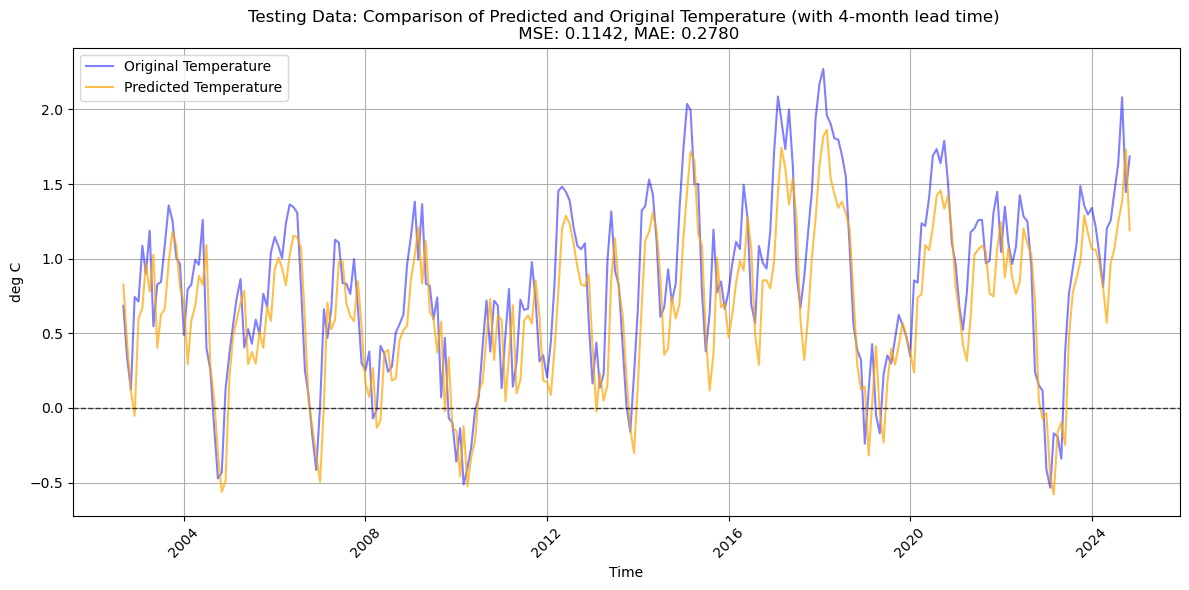

In [21]:
time_temp = Y_test.time.values
start_index = len(Y_test) - len(predictions)
time_predictions = time_temp[start_index:]

# Adjust start_index based on preprocessing
start_index = len(Y_test) - len(predictions)
if start_index < 0:
    raise ValueError("Predictions are longer than Y_test, check preprocessing.")

# Correct alignment of time_predictions
time_predictions = time_temp[start_index:]  # Ensure timestamps match predictions

# Verify alignment
assert len(time_predictions) == len(
    predictions
), "Timestamps and predictions misaligned!"

plt.figure(figsize=(12, 6))
plt.plot(time_temp, Y_test, label="Original Temperature", color="blue", alpha=0.5)
plt.plot(
    time_predictions,
    predictions,
    label="Predicted Temperature",
    color="orange",
    alpha=0.7,
)

plt.title(
    "Testing Data: Comparison of Predicted and Original Temperature (with 4-month lead time) \n MSE: {:.4f}, MAE: {:.4f}".format(
        test_mse, test_mae
    )
)
plt.axhline(0, color="black", linestyle="--", linewidth=1, alpha=0.7)
plt.xlabel("Time")
plt.ylabel("deg C")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# plt.savefig(f"../figs/predictions_test_{exp_name}.png", dpi=300)

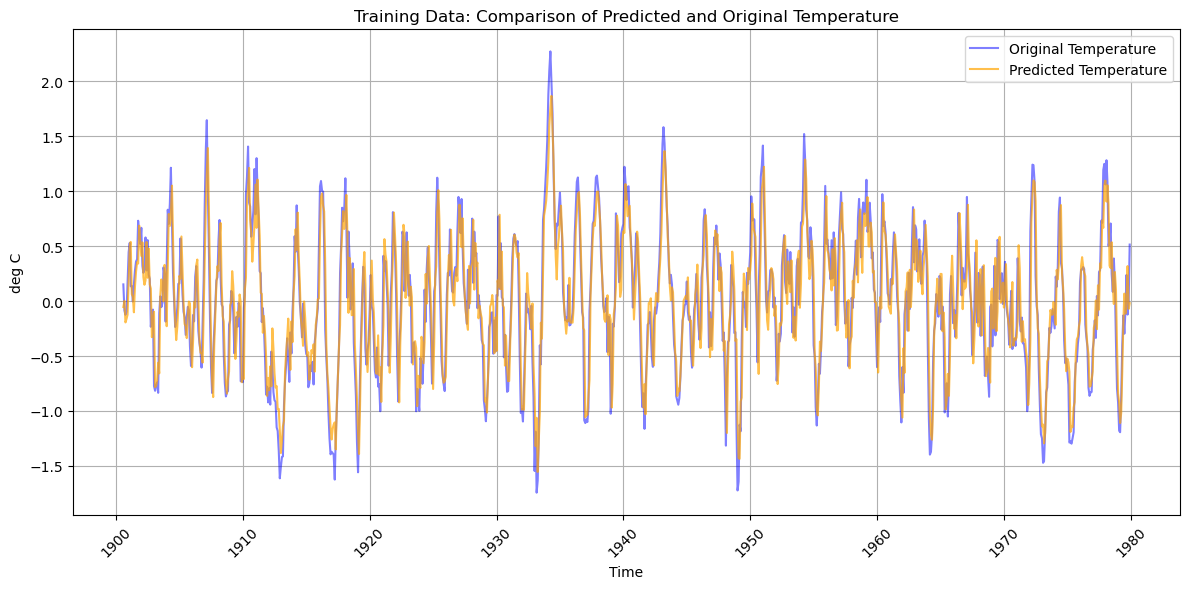

In [22]:
time_temp = Y_train.time.values
start_index = len(Y_train) - len(predictions_train)

time_predictions = time_temp[start_index:]

plt.figure(figsize=(12, 6))
plt.plot(time_temp, Y_train, label="Original Temperature", color="blue", alpha=0.5)
plt.plot(
    time_predictions,
    predictions_train,
    label="Predicted Temperature",
    color="orange",
    alpha=0.7,
)

plt.title("Training Data: Comparison of Predicted and Original Temperature")
plt.xlabel("Time")
plt.ylabel("deg C")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.tight_layout()
plt.show()
# plt.savefig(f"../figs/predictions_train_{exp_name}.png", dpi=300)

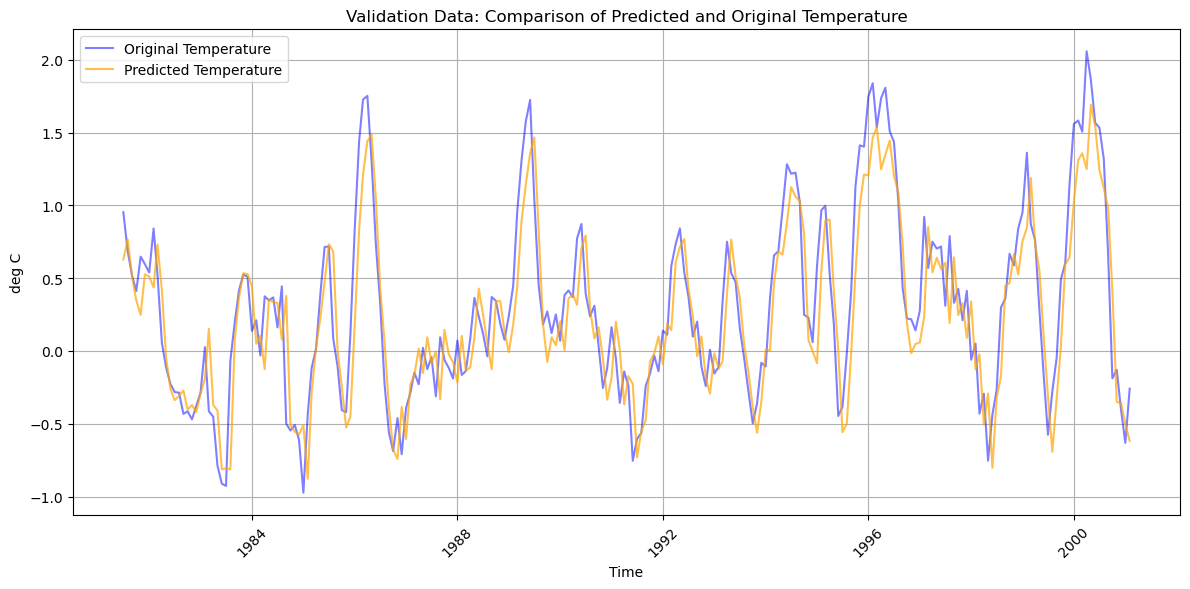

In [23]:
time_temp = Y_val.time.values
start_index = len(Y_val) - len(predictions_val)

time_predictions = time_temp[start_index:]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_temp, Y_val, label="Original Temperature", color="blue", alpha=0.5)
plt.plot(
    time_predictions,
    predictions_val,
    label="Predicted Temperature",
    color="orange",
    alpha=0.7,
)

plt.title("Validation Data: Comparison of Predicted and Original Temperature")
plt.xlabel("Time")
plt.ylabel("deg C")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.tight_layout()
plt.show()
# plt.savefig(f"../figs/predictions_val_{exp_name}.png", dpi=300)

# Save predictions and metrics for future use

In [24]:
# Combine  predictions, labels, and time into a dataset
# Convert everything to NumPy arrays for compatibility with xarray
train_preds_np = train_preds  # Predictions from the training set
val_preds_np = val_preds  # Predictions from the validation set
test_preds_np = test_preds  # Predictions from the test set

train_labels_np = Y_train.values
val_labels_np = Y_val.values
test_labels_np = Y_test.values

ds = xr.Dataset(
    {
        "train_predictions": (
            ["time_train"],
            train_preds_np.squeeze(),
        ),  # Ensure it's 1D
        "train_labels": (["time_train"], train_labels_np.squeeze()),
        "val_predictions": (["time_val"], val_preds_np.squeeze()),
        "val_labels": (["time_val"], val_labels_np.squeeze()),
        "test_predictions": (["time_test"], test_preds_np.squeeze()),
        "test_labels": (["time_test"], test_labels_np.squeeze()),
        "test_labels_clean": (
            ["time_test"],
            test_labels_clean_arr.squeeze(),
        ),  # Add clean labels
        "metrics": (
            ["metric_type"],
            [train_mse, train_mae, val_mse, val_mae, test_mse, test_mae],
        ),
        "metrics_clean": (
            ["metric_type_clean"],
            [test_mse_clean, test_mae_clean],
        ),
    },
    coords={
        "time_train": Y_train.time.values,  # Ensure it matches `train_labels` shape
        "time_val": Y_val.time.values,  # Ensure it matches `val_labels` shape
        "time_test": Y_test.time.values,  # Ensure it matches `test_labels` shape
        "metric_type": [
            "train_mse",
            "train_mae",
            "val_mse",
            "val_mae",
            "test_mse",
            "test_mae",
        ],
        "metric_type_clean": [
            "test_mse_clean",
            "test_mae_clean",
        ],
    },
)

# Add attributes to document the difference
ds.attrs["description"] = "Model predictions and metrics"
ds.attrs["note"] = (
    "metrics = evaluated against processed labels; metrics_clean = evaluated against clean ground truth labels"
)

# Save the dataset to a NetCDF file
ds.to_netcdf("../output/predictions_and_metrics_" + exp_name + ".nc")
print("Saved predictions and metrics to netcdf")
print(f"Test MSE (processed): {test_mse:.4f}, Test MAE (processed): {test_mae:.4f}")
print(
    f"Test MSE (clean):     {test_mse_clean:.4f}, Test MAE (clean):     {test_mae_clean:.4f}"
)

Saved predictions and metrics to netcdf
Test MSE (processed): 0.1142, Test MAE (processed): 0.2780
Test MSE (clean):     0.1142, Test MAE (clean):     0.2780


In [25]:
# Load the NetCDF files for plotting
ds_clean = xr.open_dataset("../output/predictions_and_metrics_CLEAN.nc")
ds_trend = xr.open_dataset("../output/predictions_and_metrics_trend.nc")
ds_climo = xr.open_dataset("../output/predictions_and_metrics_climo.nc")
ds_split = xr.open_dataset("../output/predictions_and_metrics_split.nc")
ds_all = xr.open_dataset("../output/predictions_and_metrics_split_trend_climo.nc")

test_predictions_clean = ds_clean.test_predictions.values
test_predictions_trend = ds_trend.test_predictions.values
test_predictions_climo = ds_climo.test_predictions.values
test_predictions_split = ds_split.test_predictions.values
test_predictions_all = ds_all.test_predictions.values

test_mae_clean = ds_clean.sel(metric_type="test_mae").metrics.item()
test_mae_trend = ds_trend.sel(metric_type="test_mae").metrics.item()
test_mae_climo = ds_climo.sel(metric_type="test_mae").metrics.item()
test_mae_split = ds_split.sel(metric_type="test_mae").metrics.item()
test_mae_all = ds_all.sel(metric_type="test_mae").metrics.item()

test_mse_clean = ds_clean.sel(metric_type="test_mse").metrics.item()
test_mse_trend = ds_trend.sel(metric_type="test_mse").metrics.item()
test_mse_climo = ds_climo.sel(metric_type="test_mse").metrics.item()
test_mse_split = ds_split.sel(metric_type="test_mse").metrics.item()
test_mse_all = ds_all.sel(metric_type="test_mse").metrics.item()

# Extract MAE metrics (adjusted - against clean ground truth)
test_mae_clean_adjusted = ds_clean.sel(
    metric_type_clean="test_mae_clean"
).metrics_clean.item()
test_mae_trend_adjusted = ds_trend.sel(
    metric_type_clean="test_mae_clean"
).metrics_clean.item()
test_mae_climo_adjusted = ds_climo.sel(
    metric_type_clean="test_mae_clean"
).metrics_clean.item()
test_mae_split_adjusted = ds_split.sel(
    metric_type_clean="test_mae_clean"
).metrics_clean.item()
test_mae_all_adjusted = ds_all.sel(
    metric_type_clean="test_mae_clean"
).metrics_clean.item()

# Extract MSE metrics (adjusted - against clean ground truth)
test_mse_clean_adjusted = ds_clean.sel(
    metric_type_clean="test_mse_clean"
).metrics_clean.item()
test_mse_trend_adjusted = ds_trend.sel(
    metric_type_clean="test_mse_clean"
).metrics_clean.item()
test_mse_climo_adjusted = ds_climo.sel(
    metric_type_clean="test_mse_clean"
).metrics_clean.item()
test_mse_split_adjusted = ds_split.sel(
    metric_type_clean="test_mse_clean"
).metrics_clean.item()
test_mse_all_adjusted = ds_all.sel(
    metric_type_clean="test_mse_clean"
).metrics_clean.item()


test_labels = ds.test_labels.values
time_test = ds.time_test.values

In [26]:
time_test.shape

(267,)

In [27]:
test_labels.shape

(267,)

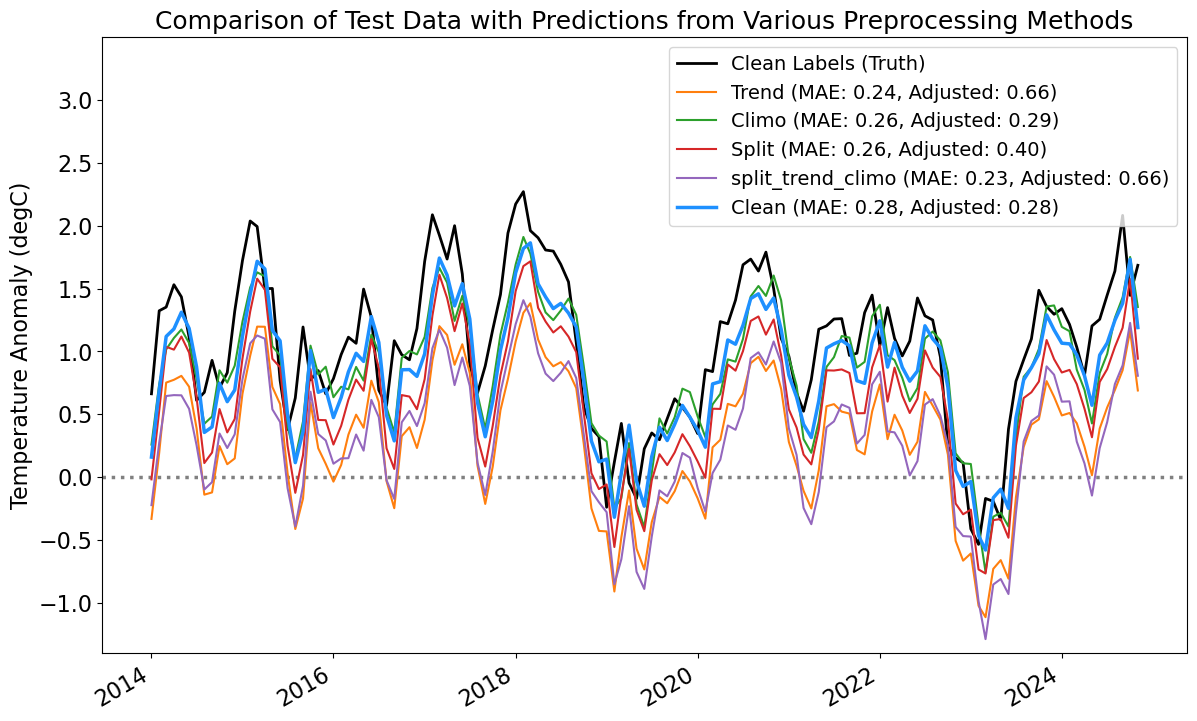

In [32]:
plt.figure(figsize=(14, 8))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
plt.axhline(0.0, color="gray", linewidth=2.5, linestyle="dotted")
# plt.plot(
#     time_test[132:],
#     test_labels[132:],
#     label="Clean Labels (Truth)",
#     color="black",
#     linewidth=2,
# )
# Use test_labels_clean from the dataset instead
ds_clean.sel(time_test=slice("2014-01-01", "2024-12-01")).test_labels_clean.plot(
    label="Clean Labels (Truth)",
    color="black",
    linewidth=2,
)

ds_trend.sel(time_test=slice("2014-01-01", "2024-12-01")).test_predictions.plot(
    label="Trend"
    + f" (MAE: {test_mae_trend:.2f}, Adjusted: {test_mae_trend_adjusted:.2f})",
    color=colors[1],
)
ds_climo.sel(time_test=slice("2014-01-01", "2024-12-01")).test_predictions.plot(
    label="Climo"
    + f" (MAE: {test_mae_climo:.2f}, Adjusted: {test_mae_climo_adjusted:.2f})",
    color=colors[2],
)
ds_split.sel(time_test=slice("2014-01-01", "2024-12-01")).test_predictions.plot(
    label="Split"
    + f" (MAE: {test_mae_split:.2f}, Adjusted: {test_mae_split_adjusted:.2f})",
    color=colors[3],
)
ds_all.sel(time_test=slice("2014-01-01", "2024-12-01")).test_predictions.plot(
    label="split_trend_climo"
    + f" (MAE: {test_mae_all:.2f}, Adjusted: {test_mae_all_adjusted:.2f})",
    color=colors[4],
)
ds_clean.sel(time_test=slice("2014-01-01", "2024-12-01")).test_predictions.plot(
    label="Clean"
    + f" (MAE: {test_mae_clean:.2f}, Adjusted: {test_mae_clean_adjusted:.2f})",
    color="dodgerblue",  # colors[0],
    linewidth=2.5,
    linestyle="-",
)
plt.yticks(np.arange(-1.5, 3.5, 0.5), fontsize=16)
plt.ylim(-1.4, 3.5)
plt.xticks(fontsize=16)
plt.xlabel("")
plt.ylabel("Temperature Anomaly (degC)", fontsize=16)
plt.legend(loc="upper right", fontsize=14)  # , bbox_to_anchor=(1.5, 0.5))
plt.title(
    "Comparison of Test Data with Predictions from Various Preprocessing Methods",
    fontsize=18,
)
# plt.show()
plt.savefig(f"../figs/predictions_comparison_{exp_name}.png", dpi=1000)

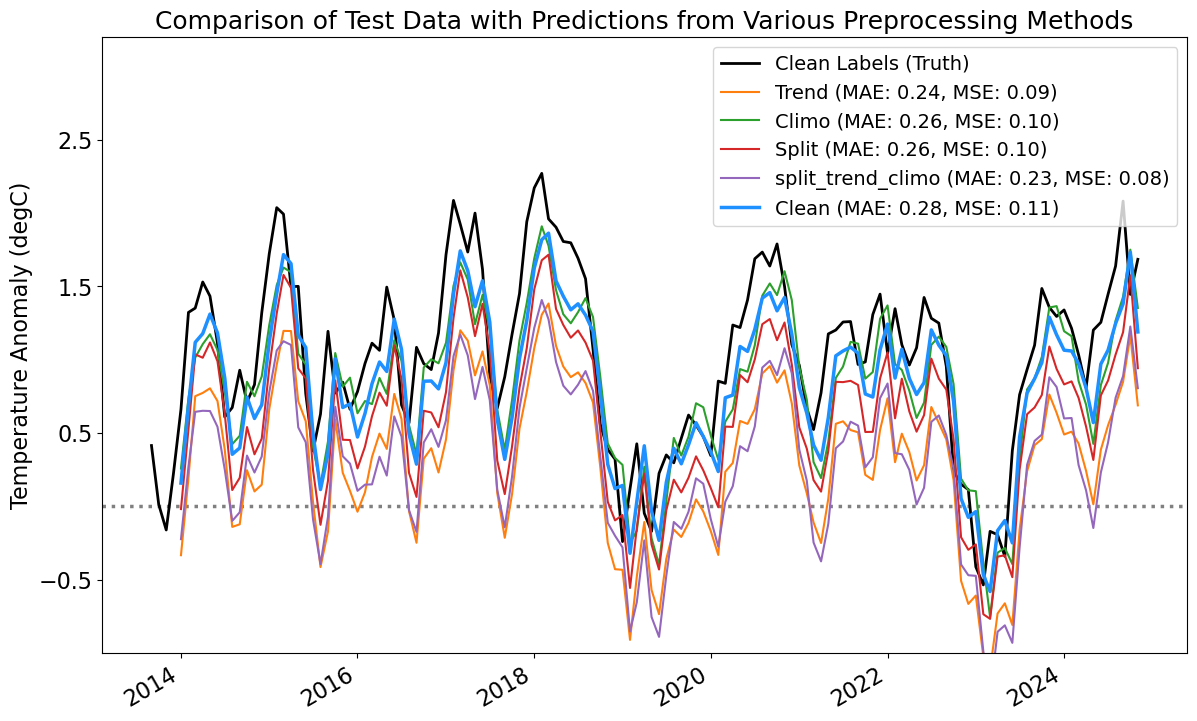

In [29]:
plt.figure(figsize=(14, 8))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

plt.axhline(0.0, color="gray", linewidth=2.5, linestyle="dotted")

plt.plot(
    time_test[132:],
    test_labels[132:],
    label="Clean Labels (Truth)",
    color="black",
    linewidth=2,
)

ds_trend.sel(time_test=slice("2014-01-01", "2024-12-01")).test_predictions.plot(
    label="Trend" + f" (MAE: {test_mae_trend:.2f}, MSE: {test_mse_trend:.2f})",
    color=colors[1],
)
ds_climo.sel(time_test=slice("2014-01-01", "2024-12-01")).test_predictions.plot(
    label="Climo" + f" (MAE: {test_mae_climo:.2f}, MSE: {test_mse_climo:.2f})",
    color=colors[2],
)
ds_split.sel(time_test=slice("2014-01-01", "2024-12-01")).test_predictions.plot(
    label="Split" + f" (MAE: {test_mae_split:.2f}, MSE: {test_mse_split:.2f})",
    color=colors[3],
)
ds_all.sel(time_test=slice("2014-01-01", "2024-12-01")).test_predictions.plot(
    label="split_trend_climo" + f" (MAE: {test_mae_all:.2f}, MSE: {test_mse_all:.2f})",
    color=colors[4],
)
ds_clean.sel(time_test=slice("2014-01-01", "2024-12-01")).test_predictions.plot(
    label="Clean" + f" (MAE: {test_mae_clean:.2f}, MSE: {test_mse_clean:.2f})",
    color="dodgerblue",  # colors[0],
    linewidth=2.5,
    linestyle="-",
)


plt.yticks(np.arange(-1.5, 3), fontsize=16)
plt.ylim(-1, 3.2)
plt.xticks(fontsize=16)
plt.xlabel("")
plt.ylabel("Temperature Anomaly (degC)", fontsize=16)
plt.legend(loc="upper right", fontsize=14)  # , bbox_to_anchor=(1.5, 0.5))
plt.title(
    "Comparison of Test Data with Predictions from Various Preprocessing Methods",
    fontsize=18,
)
# plt.show()
# plt.savefig(f"../figs/predictions_comparison_{exp_name}.png", dpi=1000)

Text(0.5, 1.0, 'Comparison of Test Data with Predictions from Various Preprocessing Methods')

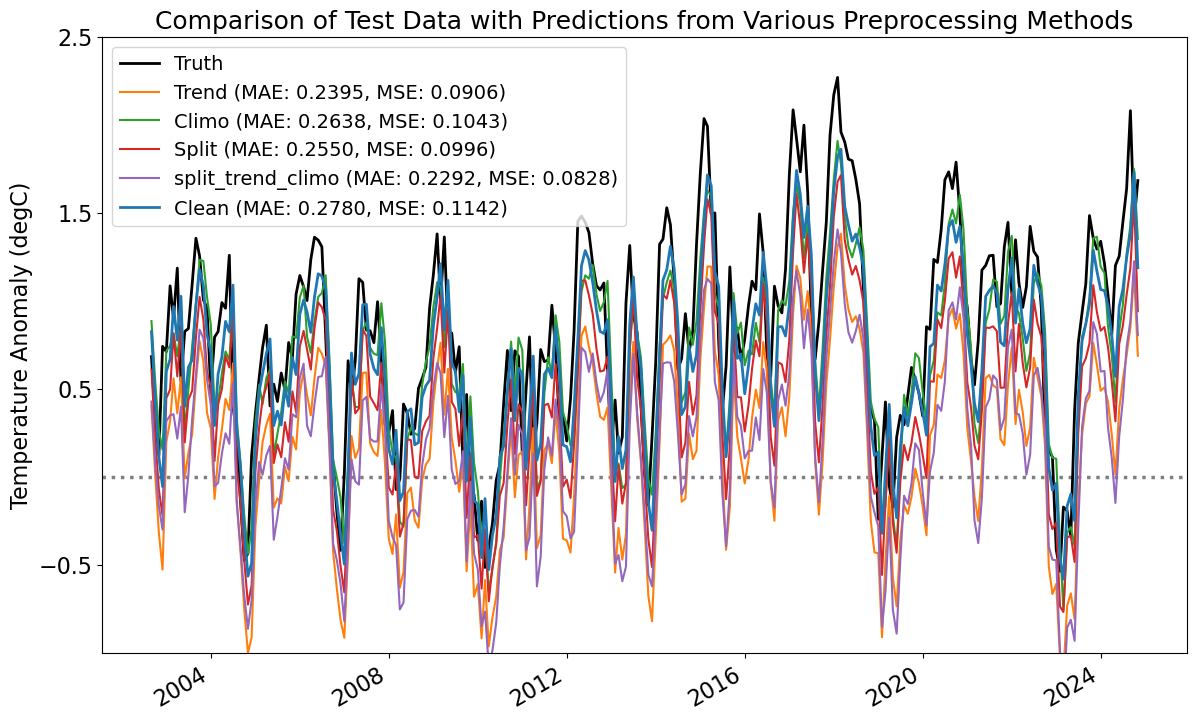

In [30]:
# Plot full test period- harder to see differences

plt.figure(figsize=(14, 8))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

plt.axhline(0.0, color="gray", linewidth=2.5, linestyle="dotted")

plt.plot(time_test, test_labels, label="Truth", color="black", linewidth=2)
ds_trend.sel(time_test=slice("2001-01-01", "2024-11-01")).test_predictions.plot(
    label="Trend" + f" (MAE: {test_mae_trend:.4f}, MSE: {test_mse_trend:.4f})",
    color=colors[1],
)
ds_climo.sel(time_test=slice("2001-01-01", "2024-11-01")).test_predictions.plot(
    label="Climo" + f" (MAE: {test_mae_climo:.4f}, MSE: {test_mse_climo:.4f})",
    color=colors[2],
)
ds_split.sel(time_test=slice("2001-01-01", "2024-11-01")).test_predictions.plot(
    label="Split" + f" (MAE: {test_mae_split:.4f}, MSE: {test_mse_split:.4f})",
    color=colors[3],
)
ds_all.sel(time_test=slice("2001-01-01", "2024-11-01")).test_predictions.plot(
    label="split_trend_climo" + f" (MAE: {test_mae_all:.4f}, MSE: {test_mse_all:.4f})",
    color=colors[4],
)
ds_clean.sel(time_test=slice("2001-01-01", "2024-11-01")).test_predictions.plot(
    label="Clean" + f" (MAE: {test_mae_clean:.4f}, MSE: {test_mse_clean:.4f})",
    color=colors[0],
    linewidth=2,
)

# plt.plot(time_test, test_predictions, label="Predictions")
plt.yticks(np.arange(-1.5, 3), fontsize=16)
plt.ylim(-1, 2.5)
plt.xticks(fontsize=16)
plt.xlabel("")
plt.ylabel("Temperature Anomaly (degC)", fontsize=16)
plt.legend(loc="upper left", fontsize=14)  # , bbox_to_anchor=(1.5, 0.5))
plt.title(
    "Comparison of Test Data with Predictions from Various Preprocessing Methods",
    fontsize=18,
)
# plt.show()
# plt.savefig(f"../figs/predictions_comparison_{exp_name}.png", dpi=1000)

In [31]:
test_predictions_clean.shape

(267,)